In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

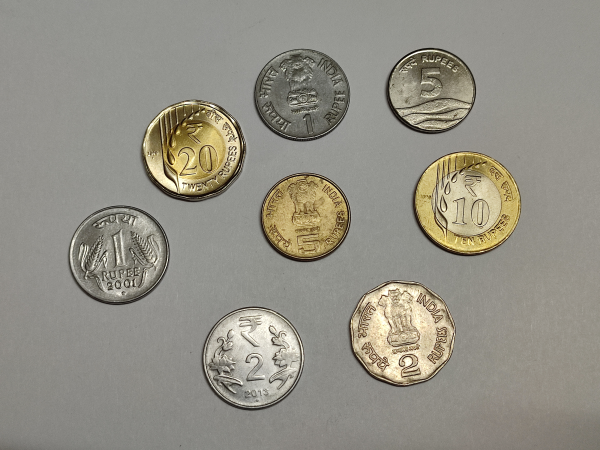

In [2]:
# Read the sample image and resize to a convenient scale
image = cv2.imread('sample.jpg')

w = 0.15 * image.shape[1]
h = 0.15 * image.shape[0]

dim = (int(w), int(h))
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(image)

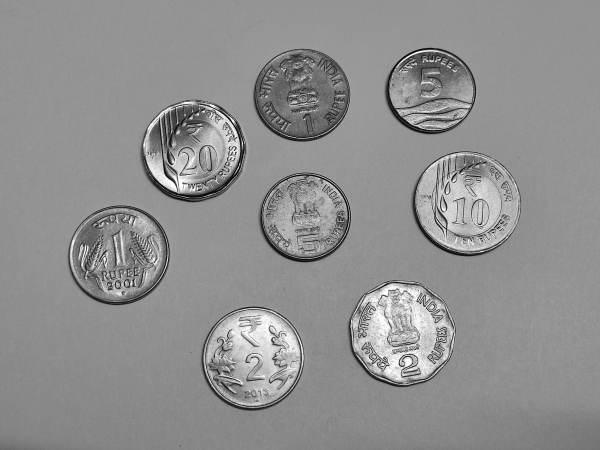

In [3]:
# Convert to grayscale
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(grayscale)

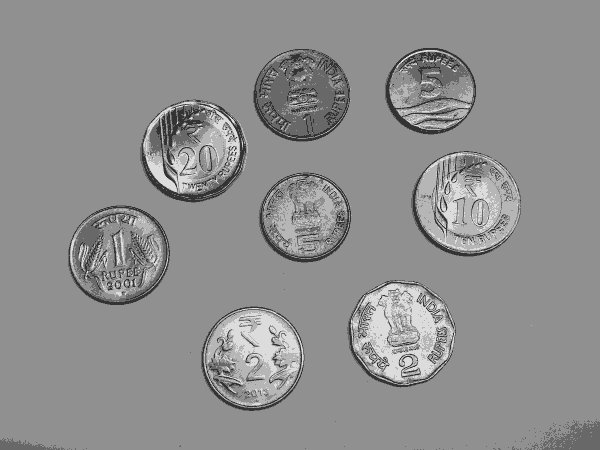

In [4]:
# Perform K-Means using 4 clusters
K = 5

Z = grayscale.reshape((-1, 1))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((grayscale.shape))

cv2_imshow(res2)

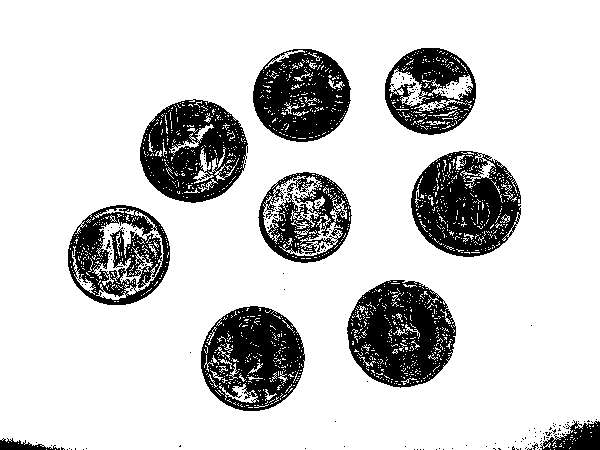

In [5]:
# Separate the background from the remaining pixels

segmented_image = label.reshape(grayscale.shape)

max_white_pixels = 0
max_centroid_index = None
max_mask = None

# Iterate through each centroid to find the one with maximum pixels

for i in range(K):
    # Create a binary mask for the current centroid:
    # white (255) where the condition is true, black (0) otherwise.
    mask = np.where(segmented_image == i, 255, 0).astype(np.uint8)

    # Count the number of white pixels (value 255)
    white_count = np.count_nonzero(mask == 255)

    # Check if this centroid has more white pixels than the previous maximum
    if white_count > max_white_pixels:
        max_white_pixels = white_count
        max_centroid_index = i
        max_mask = mask

cv2_imshow(max_mask)

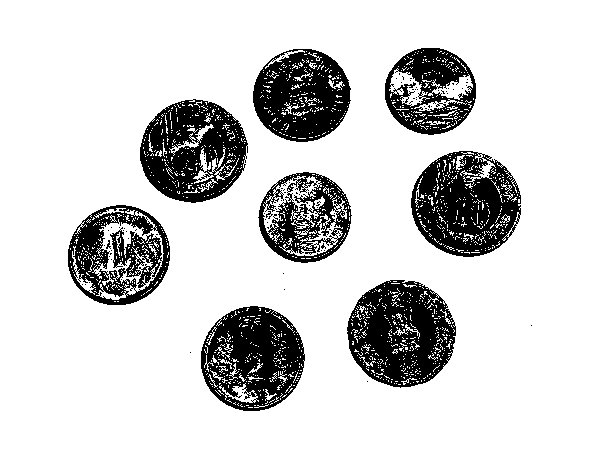

In [6]:
# Remove black pixels at the bottom
bottom_rows = int(max_mask.shape[0] * 0.07)
max_mask[-bottom_rows:, :] = 255
cv2_imshow(max_mask)

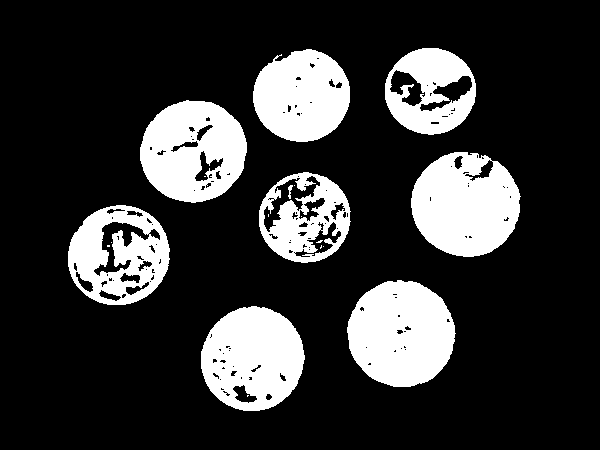

In [7]:
# Blur the image and invert colors
blur = cv2.medianBlur(max_mask, 5)
inverted = cv2.bitwise_not(blur)
cv2_imshow(inverted)

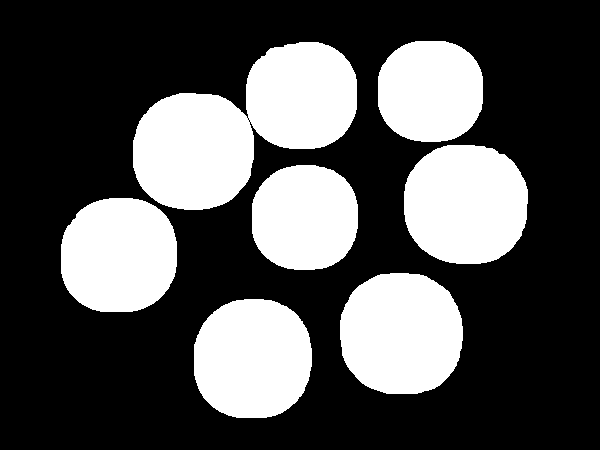

In [8]:
# Dilate the image to remove noise
kernel = np.ones((15, 15), np.uint8)
dilated = cv2.dilate(inverted, kernel, iterations=1)
cv2_imshow(dilated)

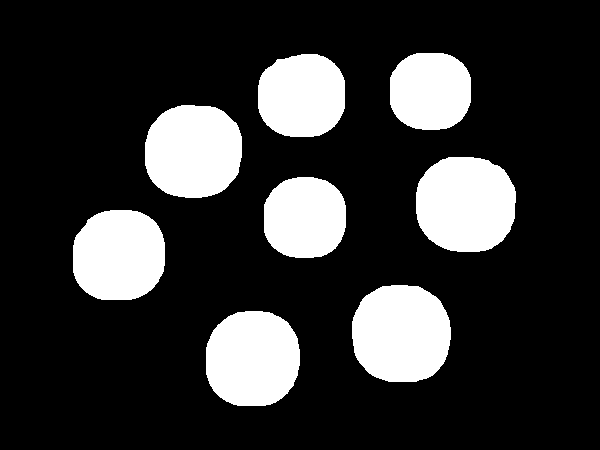

In [9]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(dilated, cv2.MORPH_OPEN,kernel, iterations = 2)

# Finding sure background and foreground
sure_bg = cv2.dilate(opening,kernel,iterations=3)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
cv2_imshow(sure_fg)

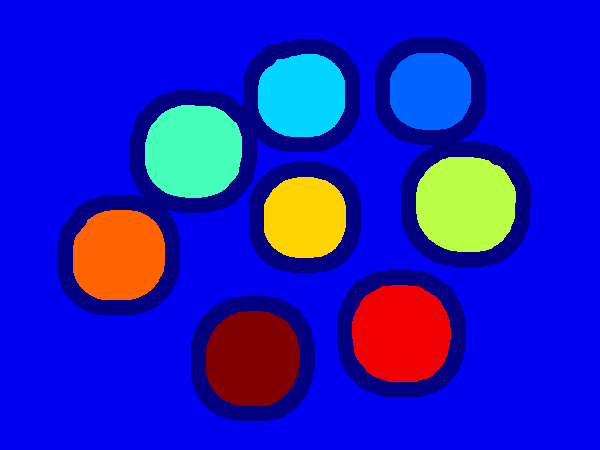

In [10]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1

# Mark the unknown region with zero
markers[unknown == 255] = 0

# Normalize the markers and apply a color map for easier visualization
markers_visual = cv2.normalize(markers, None, 0, 255, cv2.NORM_MINMAX)
markers_visual = np.uint8(markers_visual)
colored_markers = cv2.applyColorMap(markers_visual, cv2.COLORMAP_JET)

cv2_imshow(colored_markers)

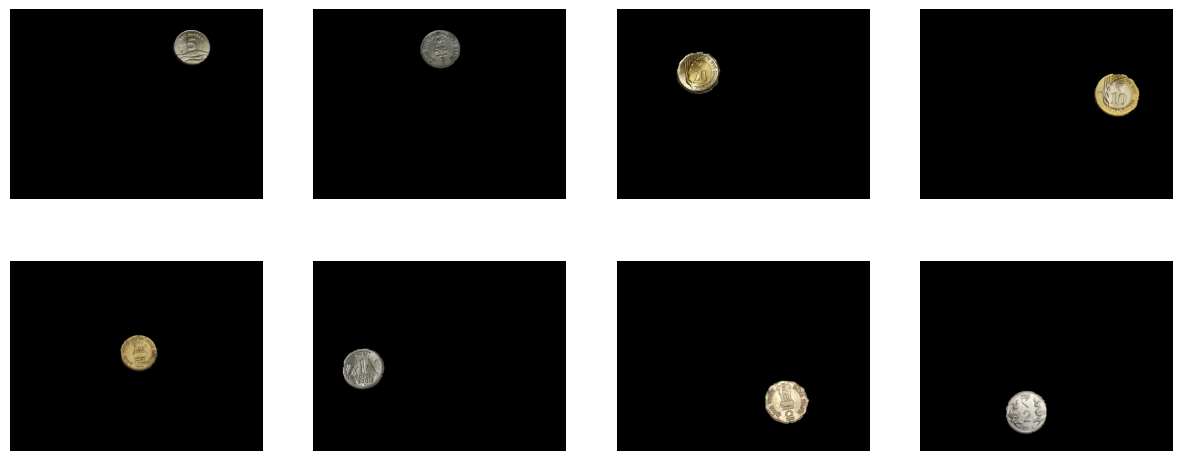

In [11]:
markers = cv2.watershed(image, markers) # Applying Watershed algorithm

# Segment the coins one by one
segmented_coins = []

for i in range(2, ret + 1):
    segmented = np.zeros_like(image)
    marker_mask = (markers == i)
    segmented[marker_mask] = image[marker_mask]
    segmented_coins.append(segmented)

fig, axes = plt.subplots(2, 4, figsize=(15, 6))
axes = axes.flatten()

# Display the coins
for i, img in enumerate(segmented_coins):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].axis("off")

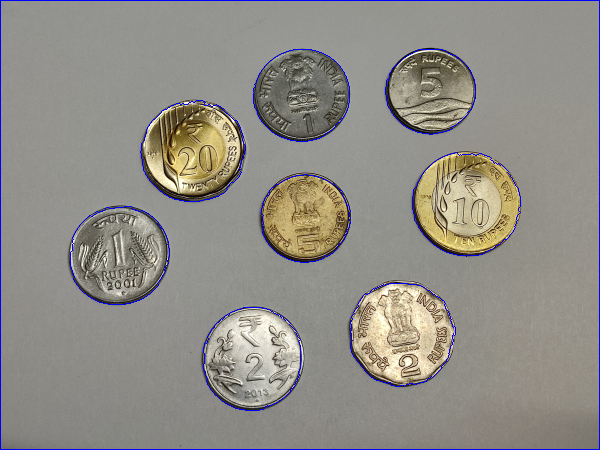

In [12]:
image[markers == -1] = [255,0,0]
cv2_imshow(image)